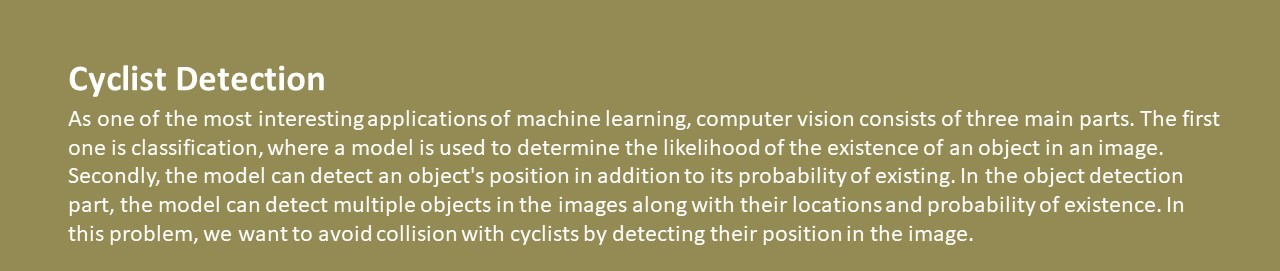

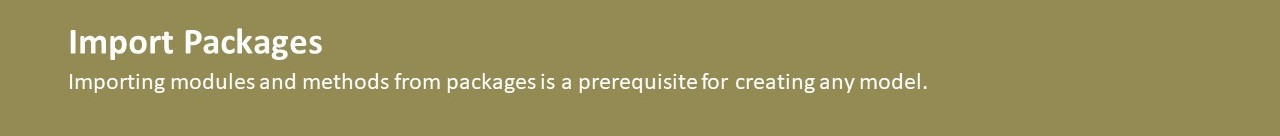

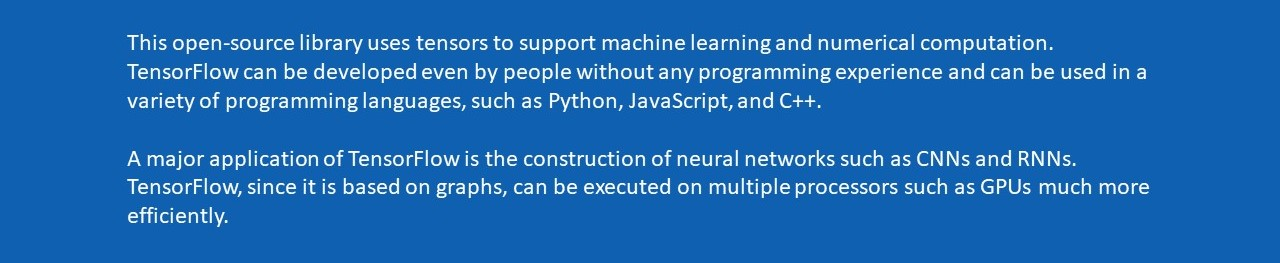

In [1]:
import tensorflow as tf

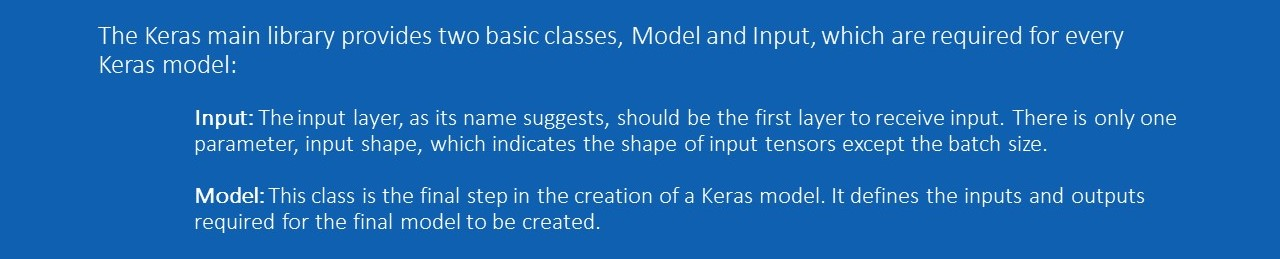

In [2]:
from tensorflow.keras import Input, Model

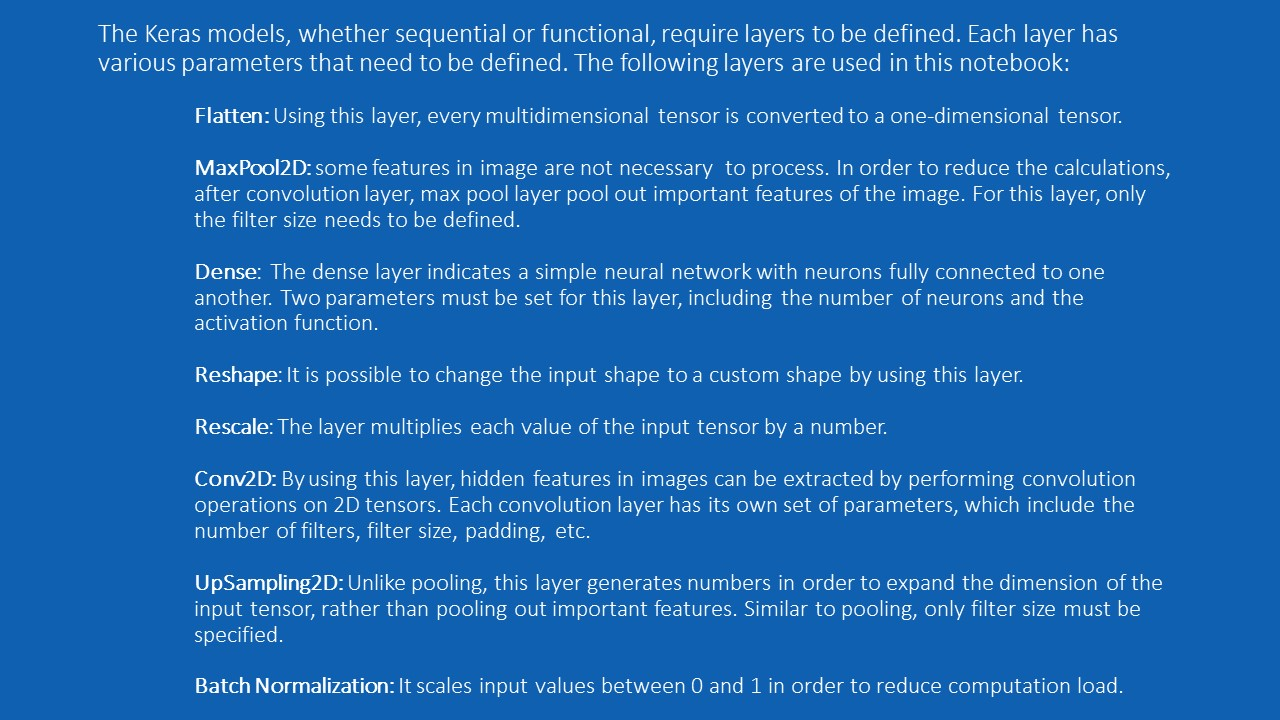

In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Reshape, Rescaling

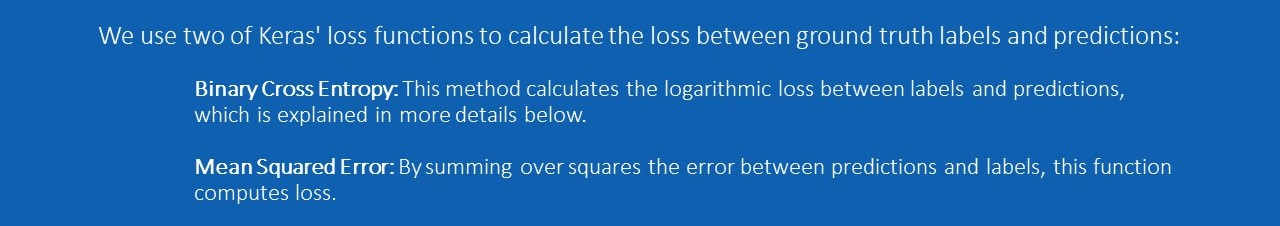

In [4]:
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

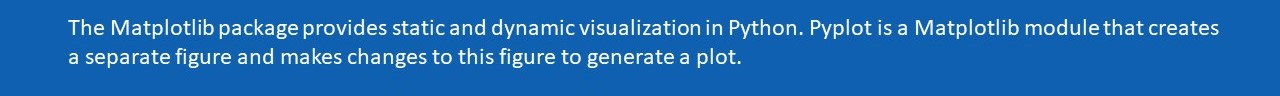

In [5]:
from matplotlib.patches import Rectangle

In [6]:
import matplotlib.pyplot as plt

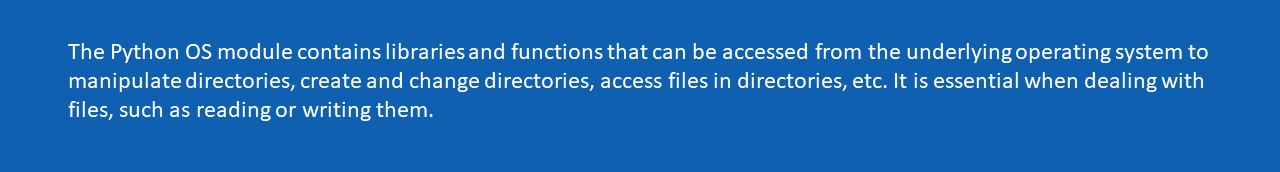

In [7]:
import os

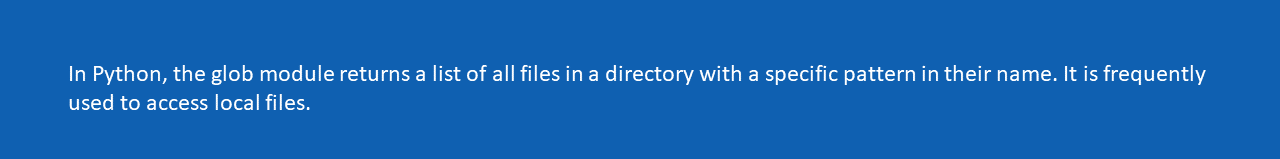

In [8]:
import glob

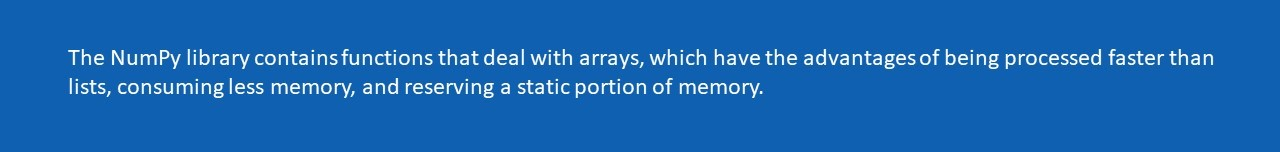

In [9]:
import numpy as np

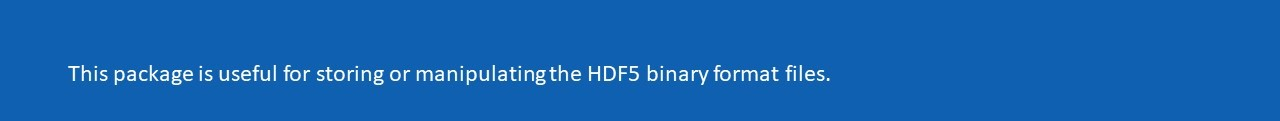

In [10]:
import h5py

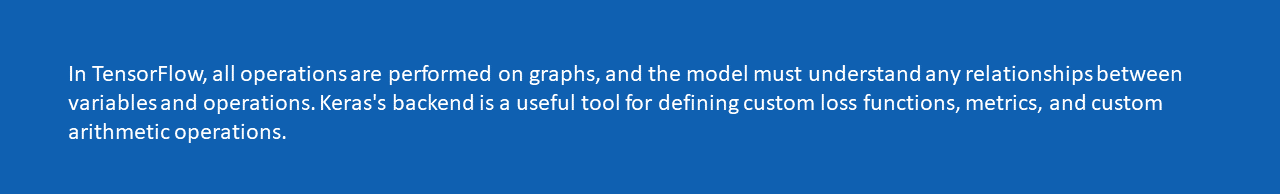

In [11]:
import tensorflow.keras.backend as K

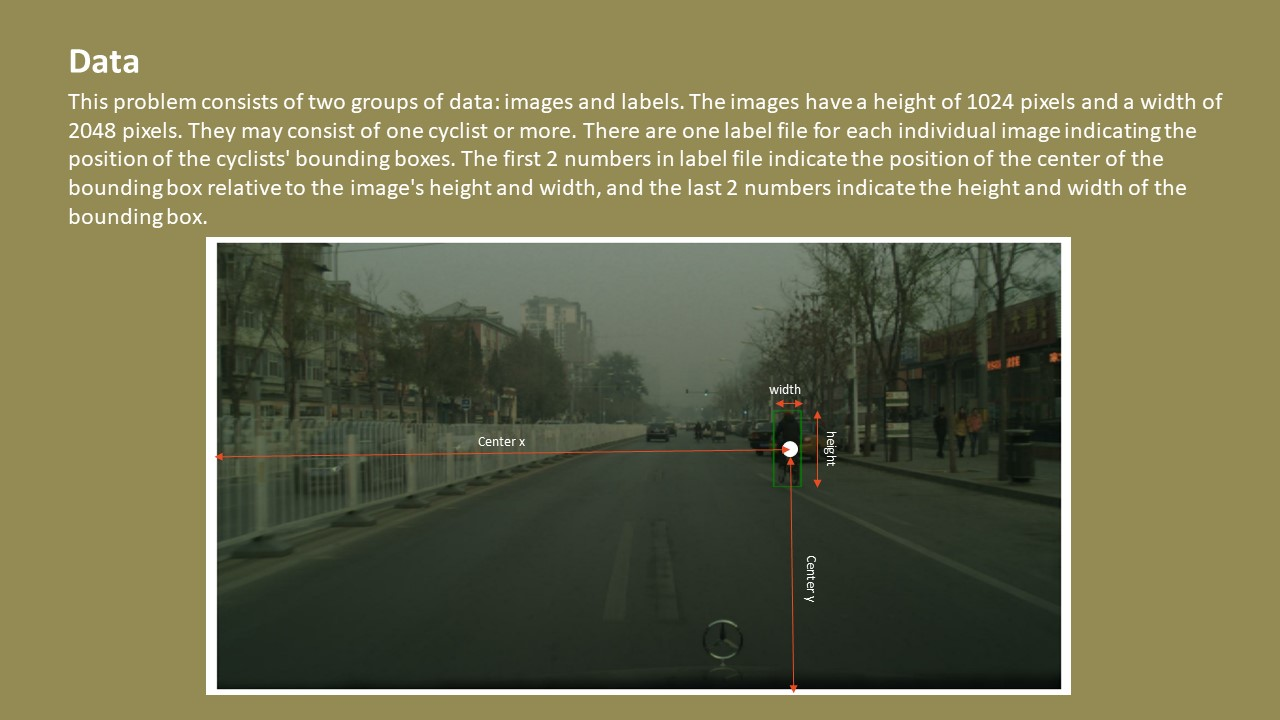

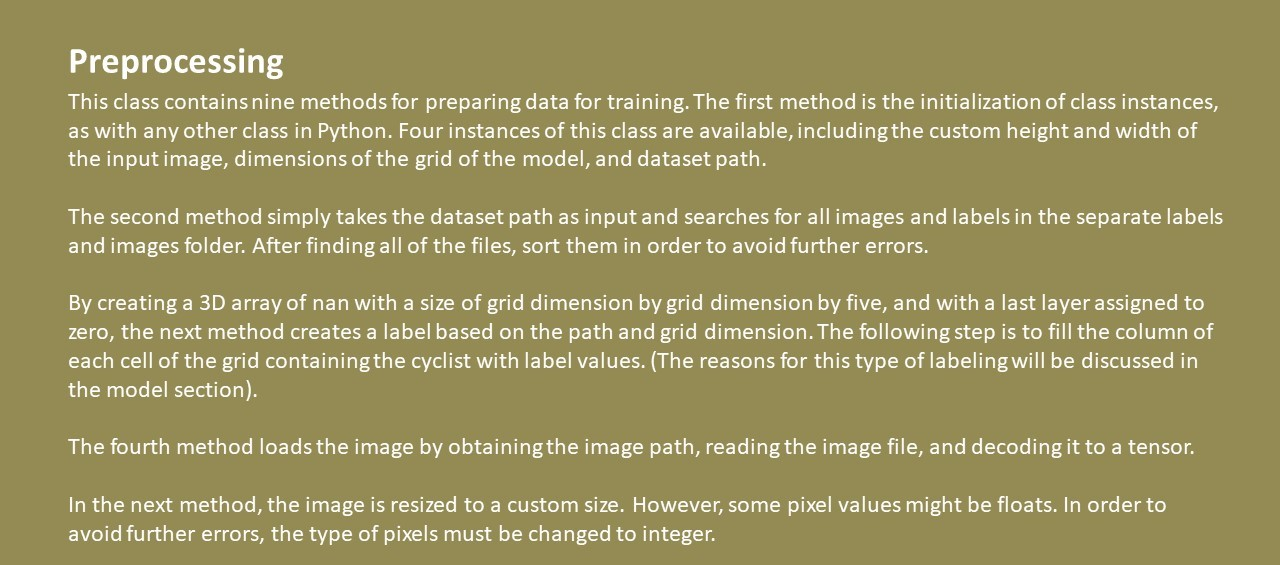

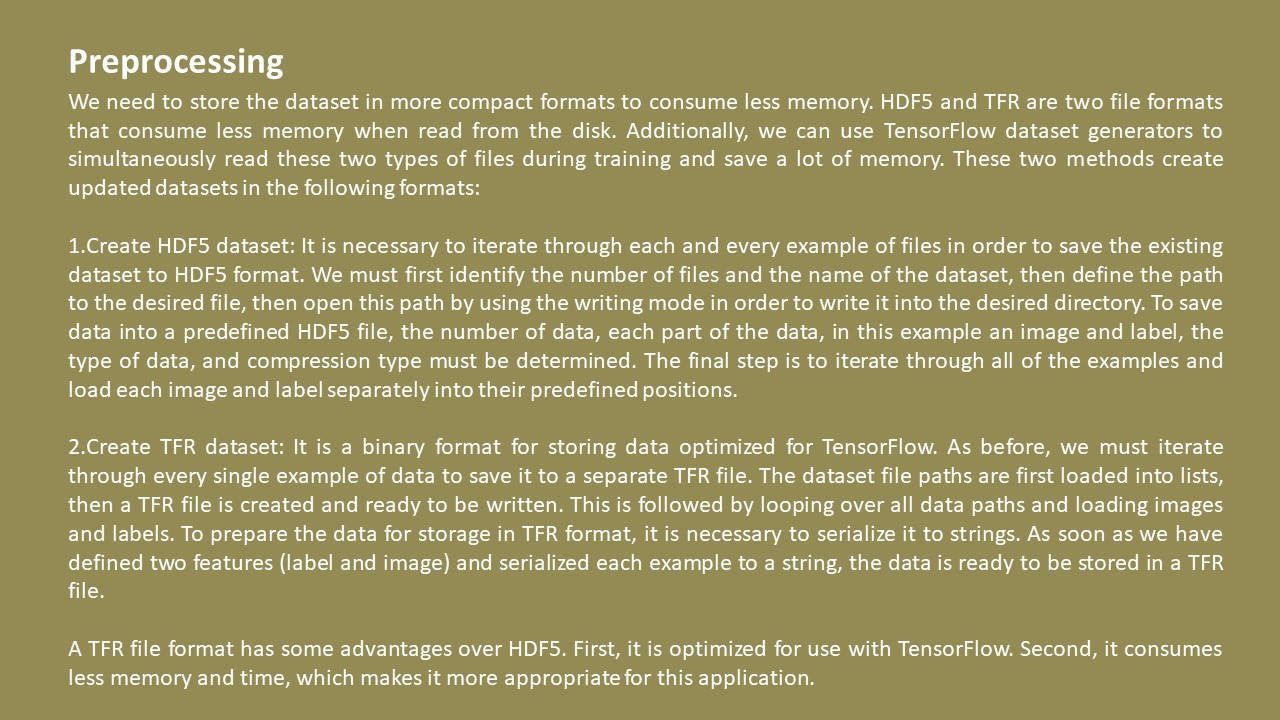

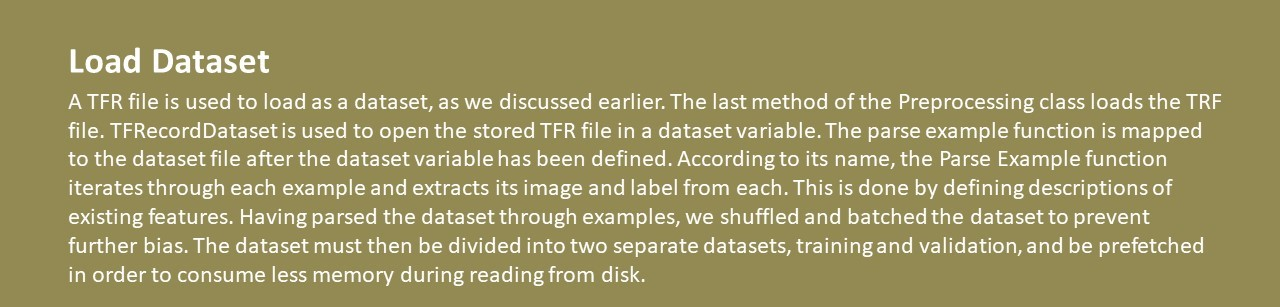

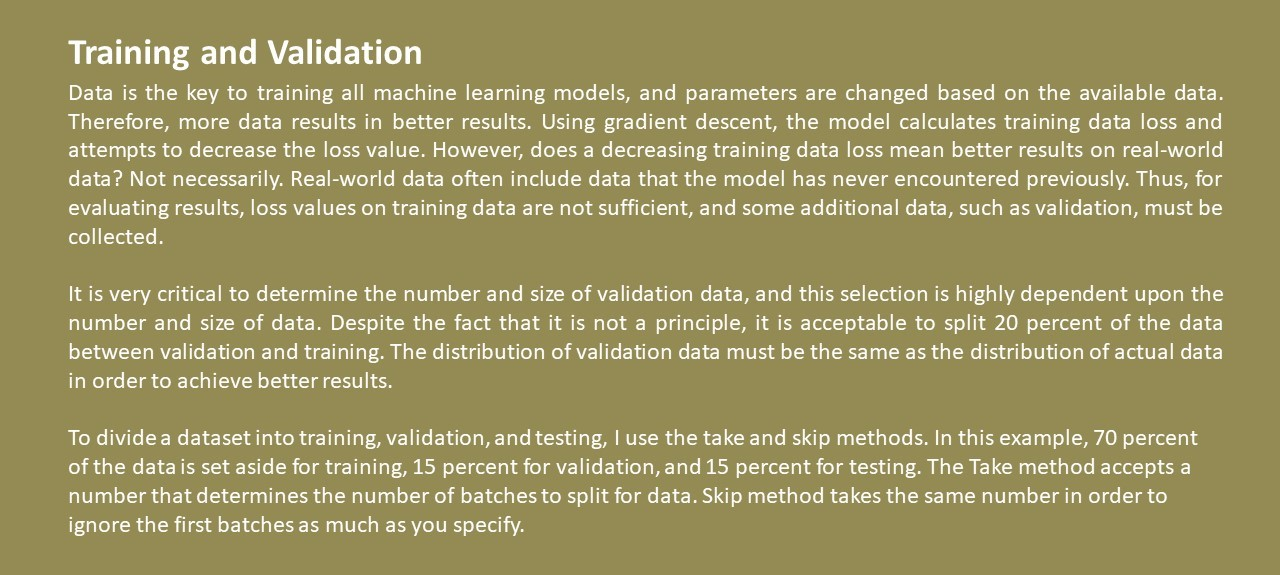

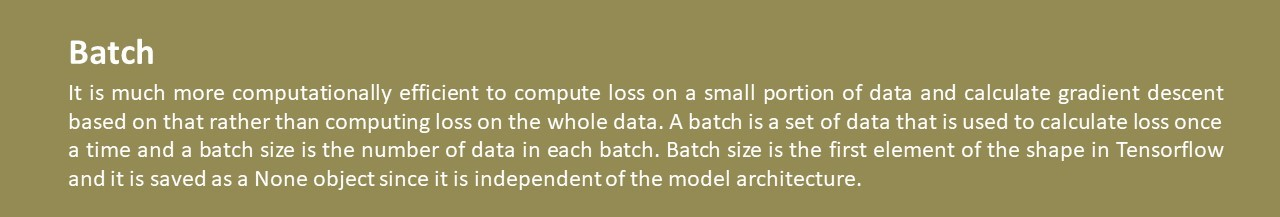

In [12]:
class Preprocessing():
  
  def __init__(self, height, width, grid_dim, data_folder_path = "/content/drive/MyDrive/Documents/AI book/Chapter 7/Chapter 7 Data/data_tsinghua"):
    self.path = data_folder_path
    self.height = height
    self.width = width
    self.grid_dim = grid_dim
  
  def __create_path(main_path):
  
    image_folder_path, label_folder_path = os.path.join(main_path, 'images/*'), os.path.join(main_path, 'labels/*')
  
    return (sorted(glob.glob(image_folder_path)), sorted(glob.glob(label_folder_path)))

  def __create_label(label_path, grid_dim):
    
    label = np.zeros((grid_dim, grid_dim, 5))
    label.fill(np.nan)
    label[:, :, 0] = 0
    
    with open(label_path) as label_file:
      selected_cells = []
      for line in label_file:
        line = np.array(line.split(), np.float16)
        line[0] = 1
        coordinate_x = int(grid_dim*line[1])
        coordinate_y = int(grid_dim*line[2])
        label[coordinate_x, coordinate_y, :] = line

    return label

  def __create_image(self, image_path):

    image_file = tf.io.read_file(image_path) 
    image = tf.io.decode_jpeg(image_file, channels=3)
    
    return image
  
  def __resize(image, height, width):
    
    image = tf.image.resize(image, [height, width])
    image = tf.cast(image, tf.uint8)
    
    return image

  def create_h5file(self):
    train_shape = 13764
    file_name = 'dataset.h5'
    file_path = os.path.join(self.path, file_name)
    hdf5_file = h5py.File(file_path, mode='w')
    train_images_shape = (train_shape, self.height, self.width, 3)
    train_labels_shape = (train_shape, self.grid_dim, self.grid_dim, 5)
    hdf5_file.create_dataset('train_images', train_images_shape, np.float16, compression='gzip')
    hdf5_file.create_dataset('train_labels', train_labels_shape, np.float16)

    image_paths, label_paths = Preprocessing.__create_path(self.path)
    for index, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
      image = self.__create_image(image_path)
      label = Preprocessing.__create_label(label_path, self.grid_dim)
      image = Preprocessing.__rescale(image)
      image = Preprocessing.__resize(image, self.height, self.width)
      hdf5_file['train_images'][index, :, :, :] = image
      hdf5_file['train_labels'][index, :, :, :] = label
    
    hdf5_file.close()

  def create_tfr_file(self):
    
    image_paths, label_paths = Preprocessing.__create_path(self.path)

    with tf.io.TFRecordWriter('/content/drive/MyDrive/Documents/AI book/Chapter 7/Chapter 7 Data/Dataset/dataset.tfrecord') as writer:
      
      for image_path, label_path in zip(image_paths, label_paths):
        
        image = self.__create_image(image_path)
        image = Preprocessing.__resize(image, self.height, self.width)
        image_file = tf.io.encode_png(image)
        label_file = Preprocessing.__create_label(label_path, self.grid_dim)
        label_file_s = tf.io.serialize_tensor(label_file)
        feature = {'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_file.numpy()])),
                   'label' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_file_s.numpy()]))}
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())

  def create_dataset(self, batch_size=16, tfr_file_path='/content/drive/MyDrive/Documents/AI book/Chapter 7/Chapter 7 Data/Dataset/dataset.tfrecord'):
    
    dataset = tf.data.TFRecordDataset(tfr_file_path)
    dataset = dataset.map(_parse_example)
    dataset = dataset.shuffle(1024).batch(batch_size, drop_remainder=True)
    
    val_dataset = dataset.take(170)
    train_dataset = dataset.skip(170)
    
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_dataset, val_dataset

In [13]:
feature_description = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}

def _parse_example(example_proto):

  example = tf.io.parse_single_example(example_proto, feature_description)
  image = tf.io.decode_png(example['image'])
  label = tf.io.parse_tensor(example['label'], out_type=tf.float64)
  
  return image, label

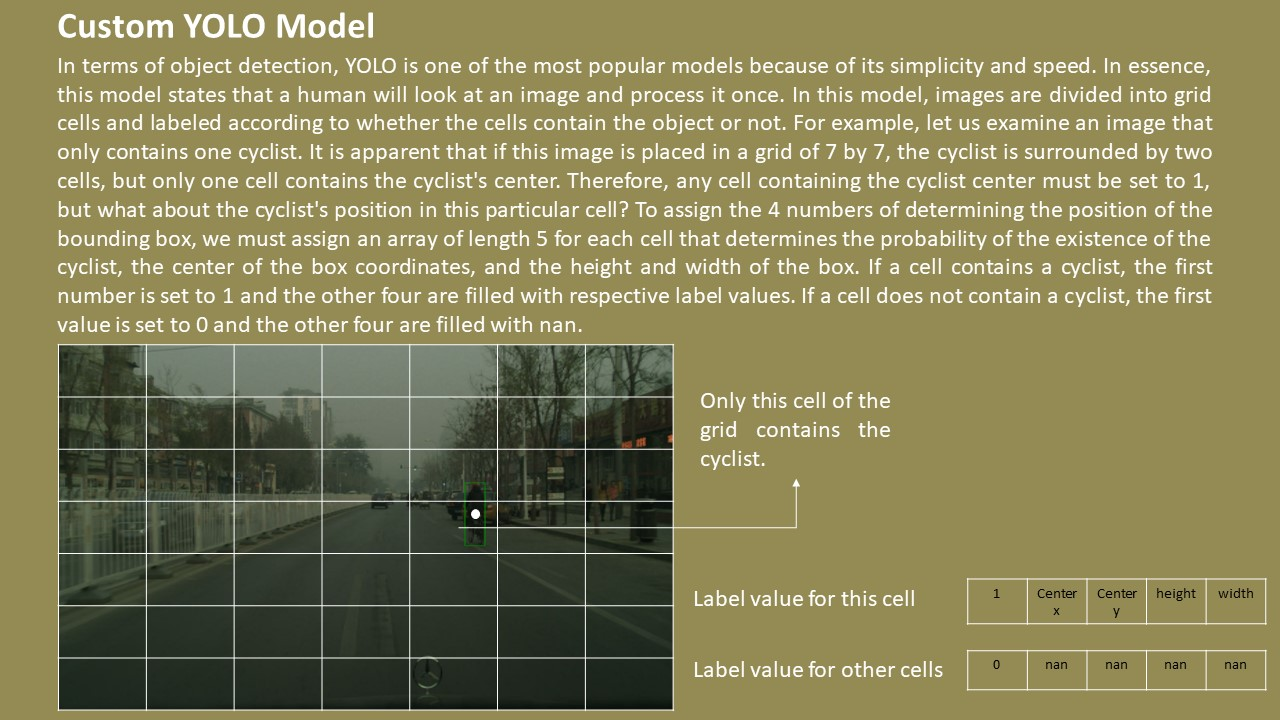

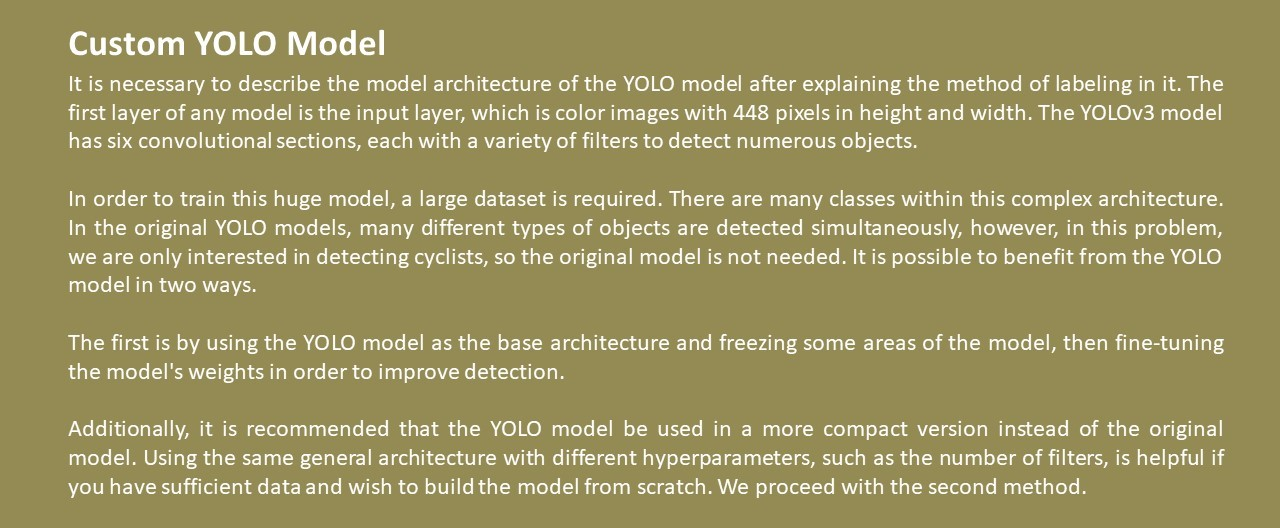

In [14]:
prep = Preprocessing(448, 448, 7)
train_dataset, val_dataset = prep.create_dataset()

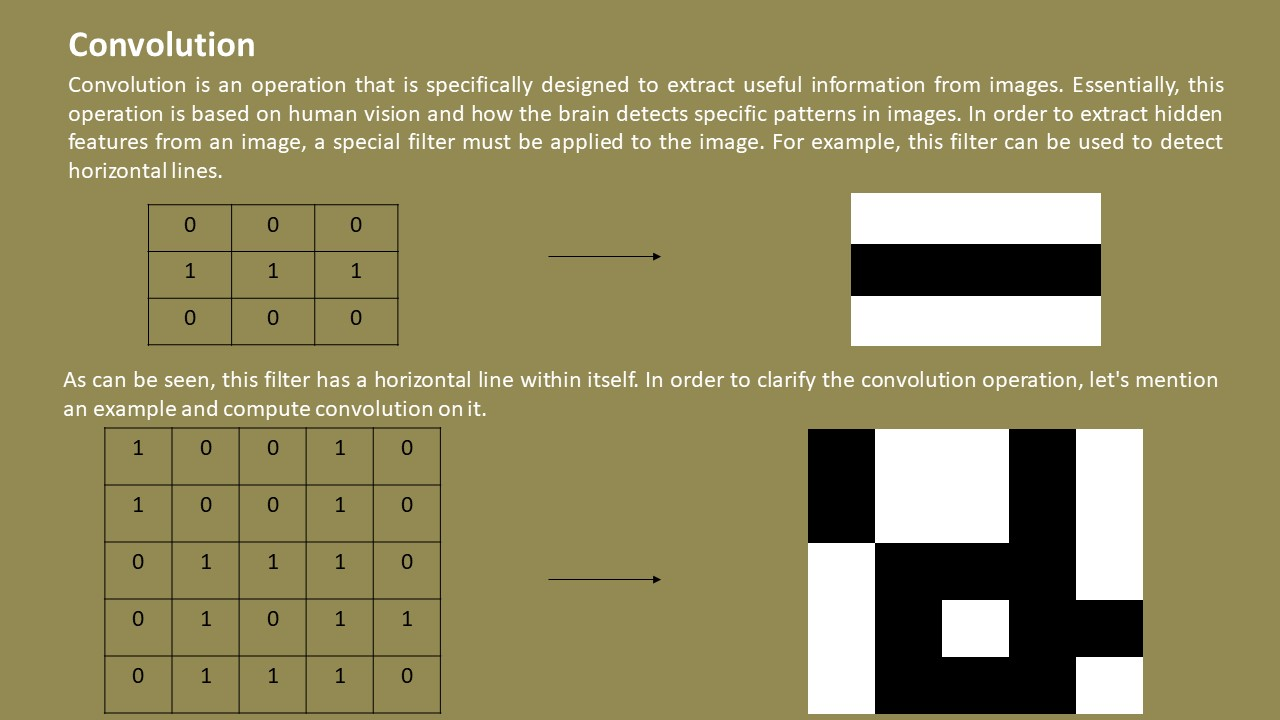

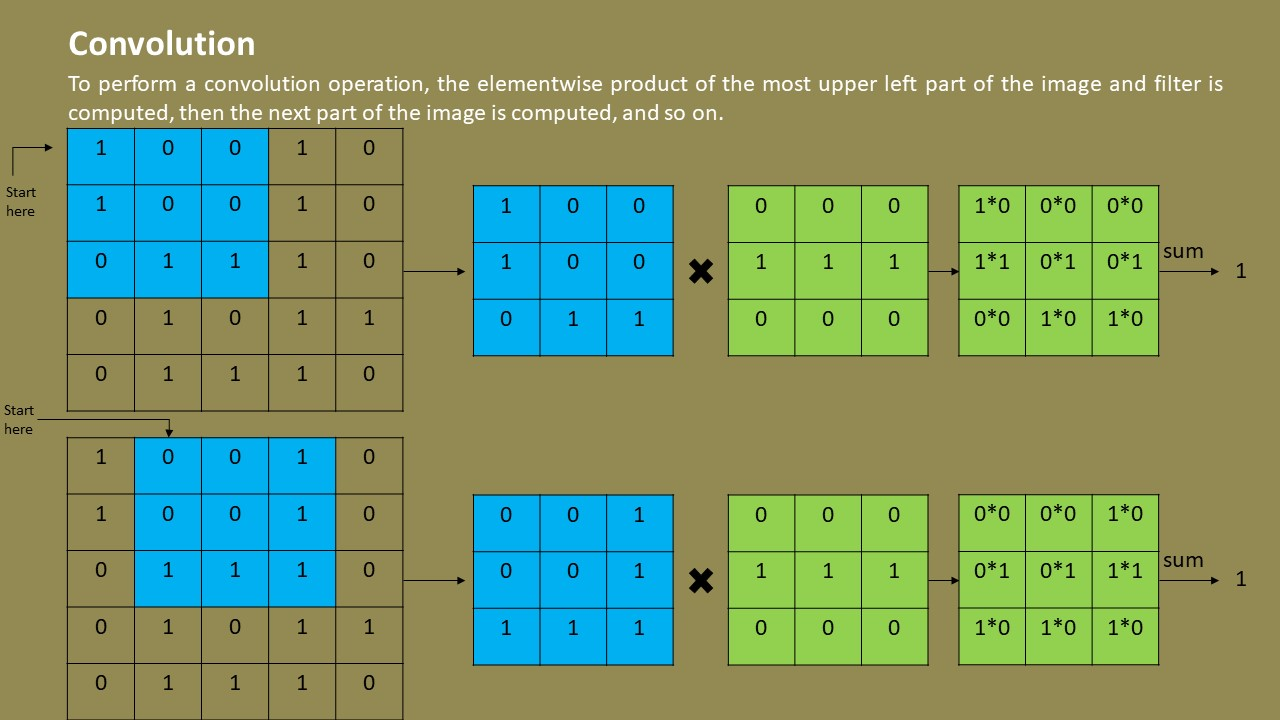

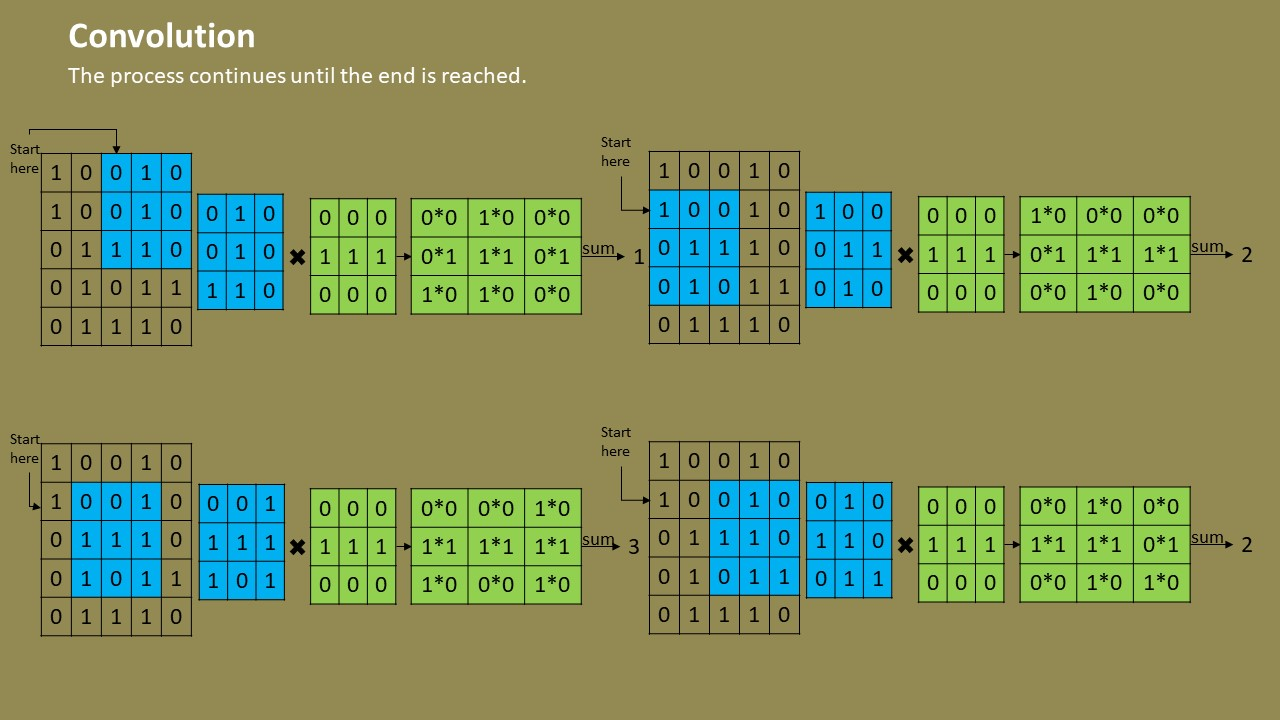

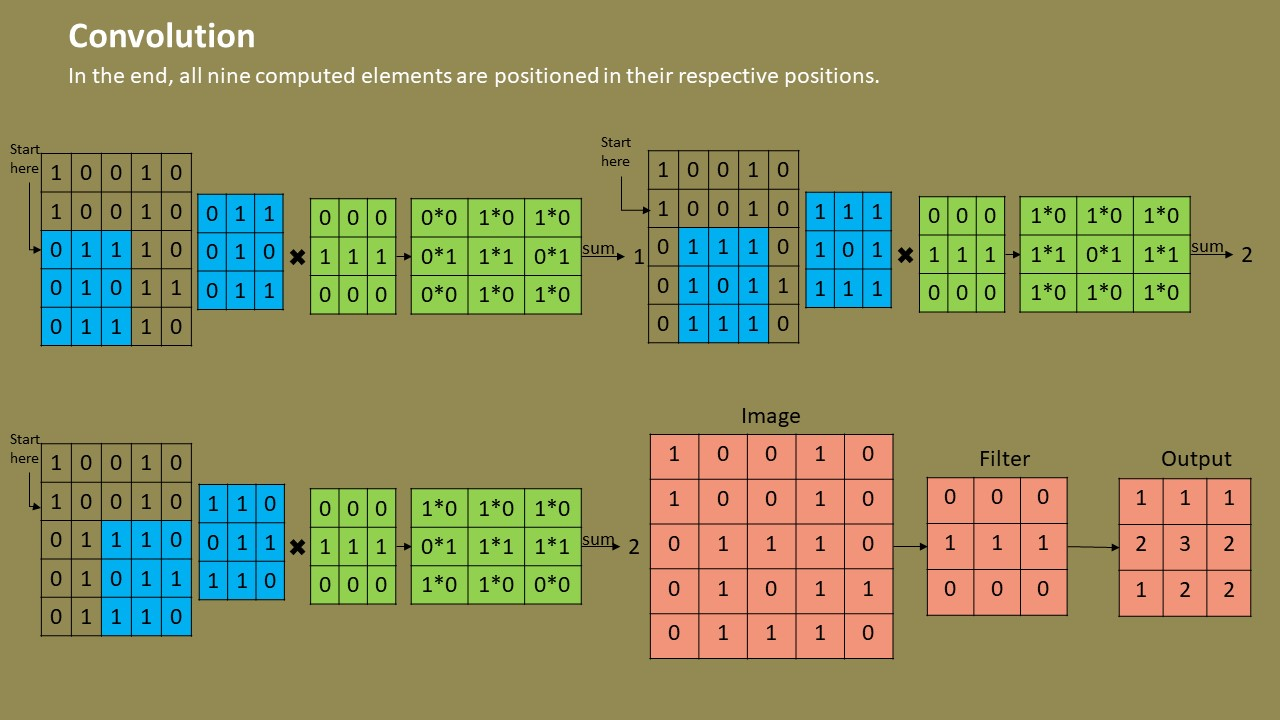

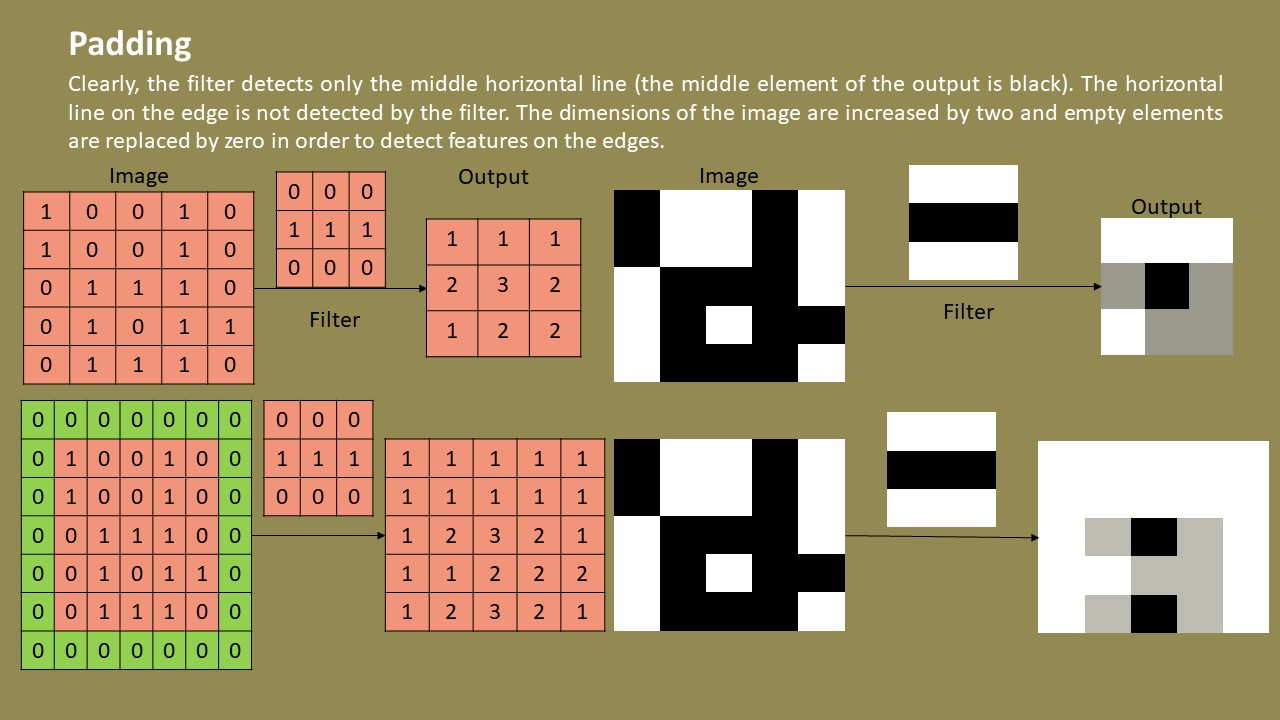

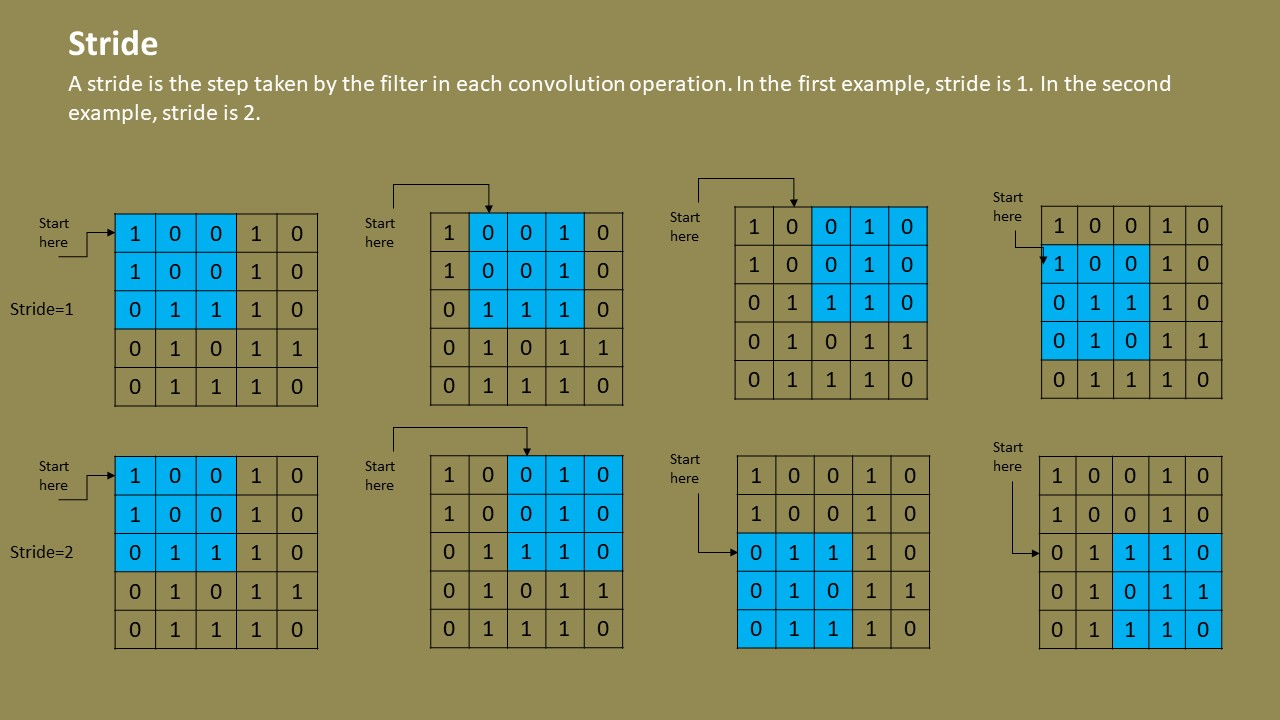

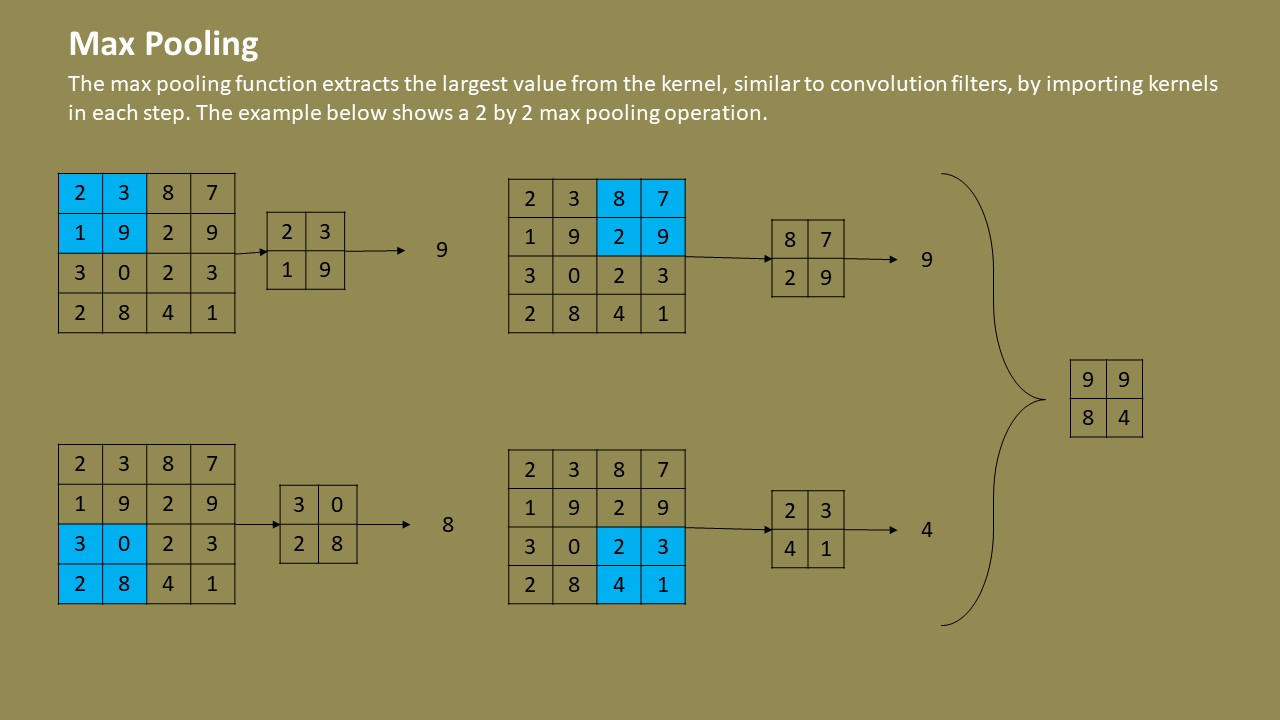

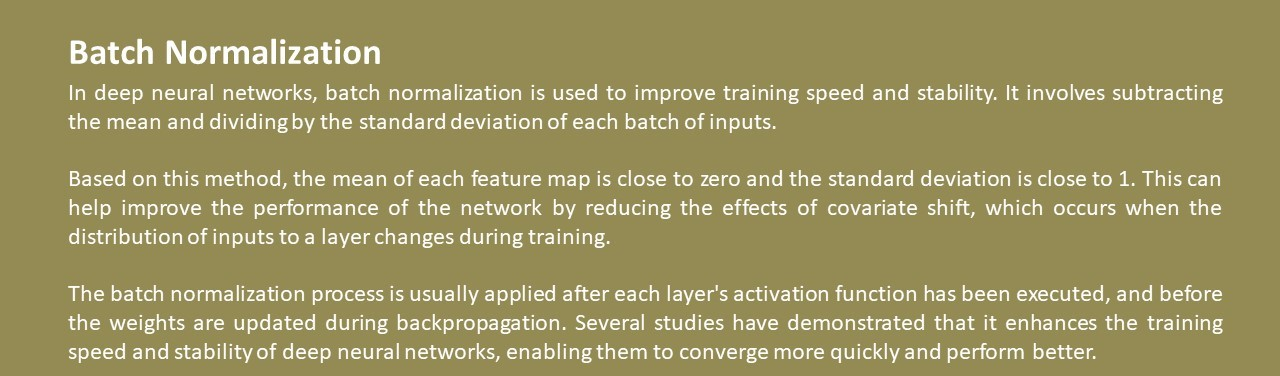

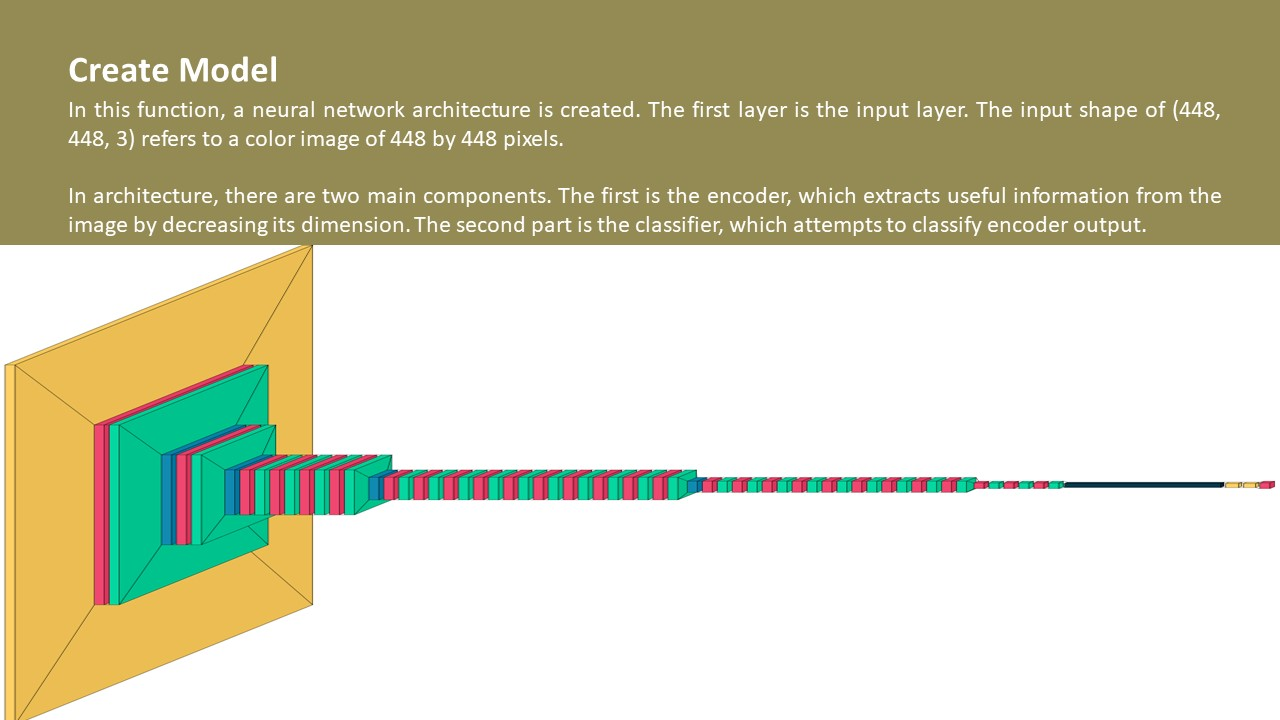

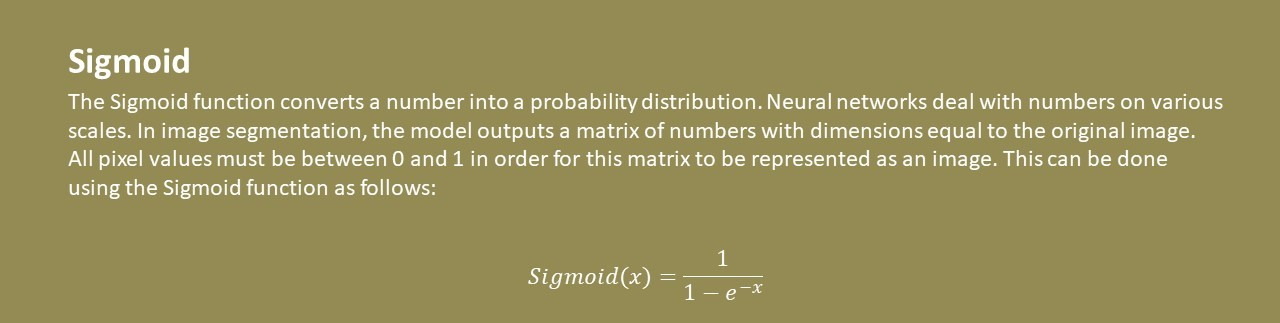

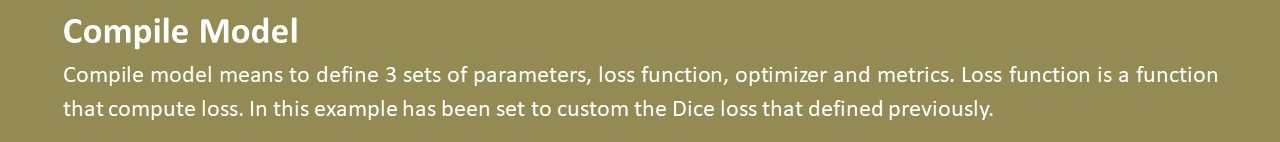

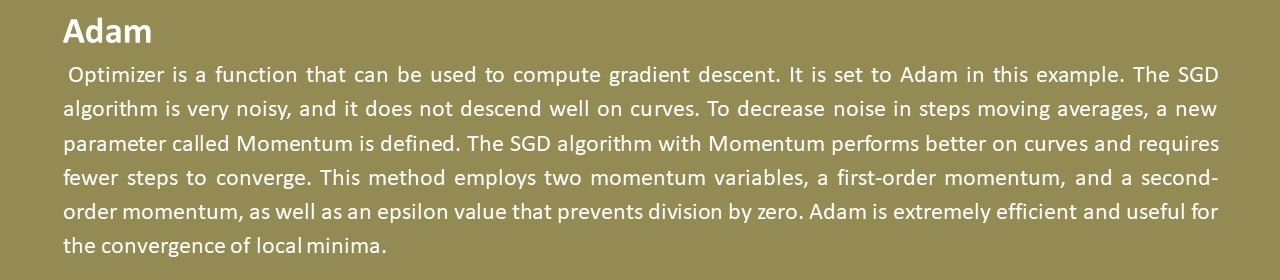

In [15]:
class Object_D_Model():

  def __init__(self):
    pass

  def create_model(self, batch_size=16, input_shape=(448, 448, 3)):
    input = Input(shape=input_shape, batch_size=batch_size)
    input = Rescaling(1/255)(input)
    x = Conv2D(8, (7, 7), 2, activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D((2,2), 2)(x)

    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2,2), 2)(x)

    x = Conv2D(8, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2), 2)(x)

    x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2), 2)(x)

    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), 2, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(245, activation='sigmoid')(x)
    x = Reshape((7, 7, 5))(x)

    return Model(inputs=input, outputs=x)

  def training(self, training_dataset, validation_dataset, batch_size=16, input_shape=(448, 448, 3), summary=True, compile=True, learning_rate=0.0001, n_epochs=50):
    
    model = self.create_model(batch_size=batch_size, input_shape=input_shape)
    
    if summary:
      print(model.summary())
    if compile:
      model.compile(loss=CustomLoss(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    history = model.fit(training_dataset, validation_data=validation_dataset, epochs=n_epochs)

    return model, history

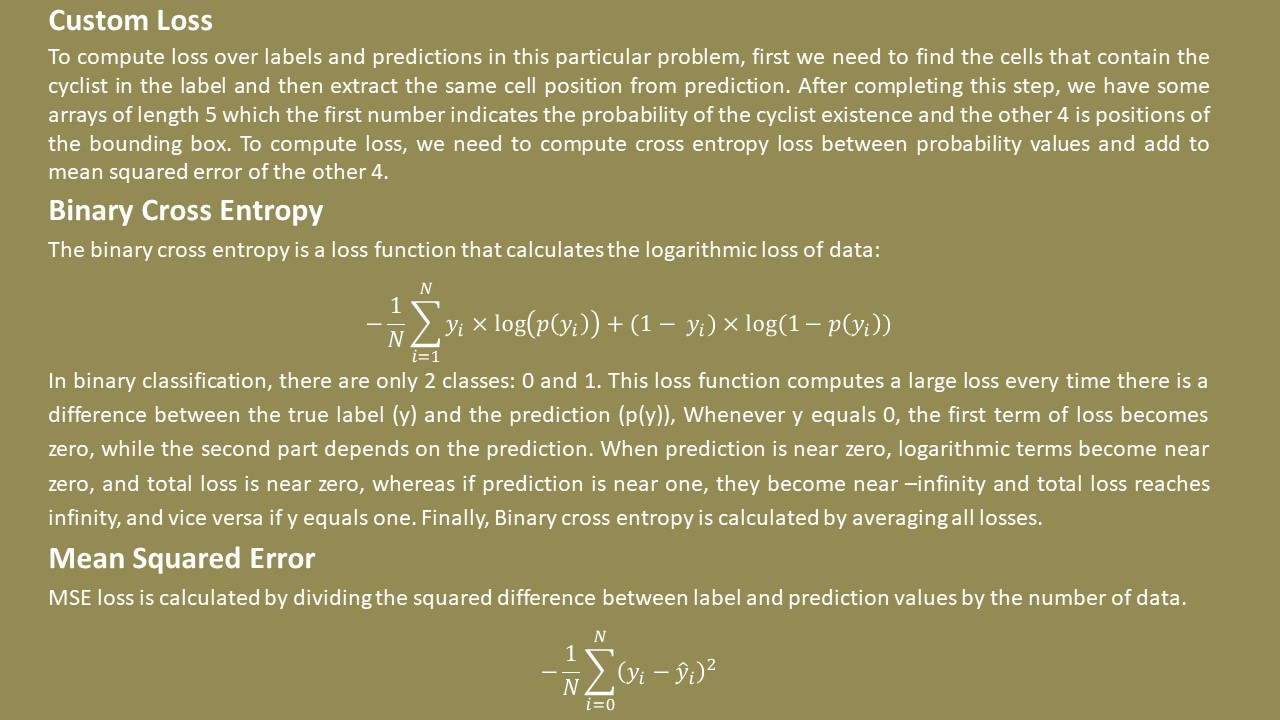

In [16]:
@tf.function
def custom_loss(y_true, y_pred):
  classes = y_true[:, :, :, 0]
  pred_classes = y_pred[:, :, :, 0]
  indices = tf.where(y_true[:, :, :, 0]==1)
  loss_value = BinaryCrossentropy()(classes, pred_classes)
  for index in indices:
    loss_value += MeanSquaredError()(y_true[index[0], index[1], index[2], 1:], y_pred[index[0], index[1], index[2], 1:]) 

  return loss_value

class CustomLoss(tf.keras.losses.Loss):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        return custom_loss(y_true, y_pred)

    def get_config(self):
        config = super().get_config()
        return config


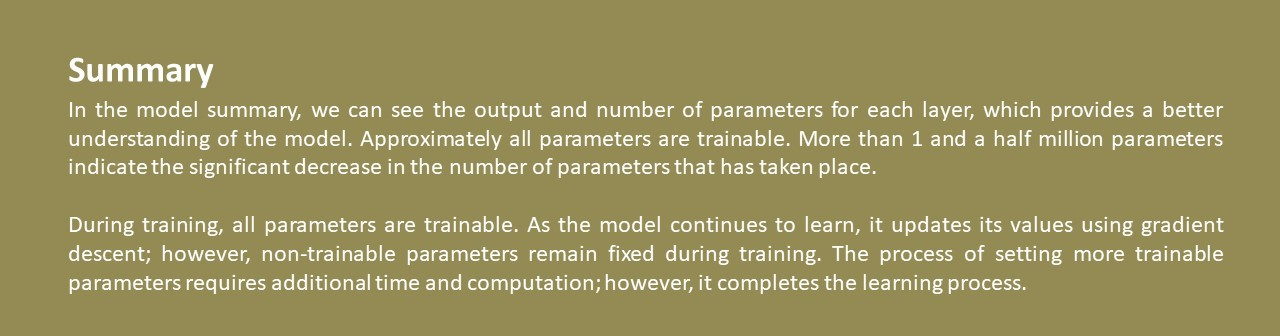

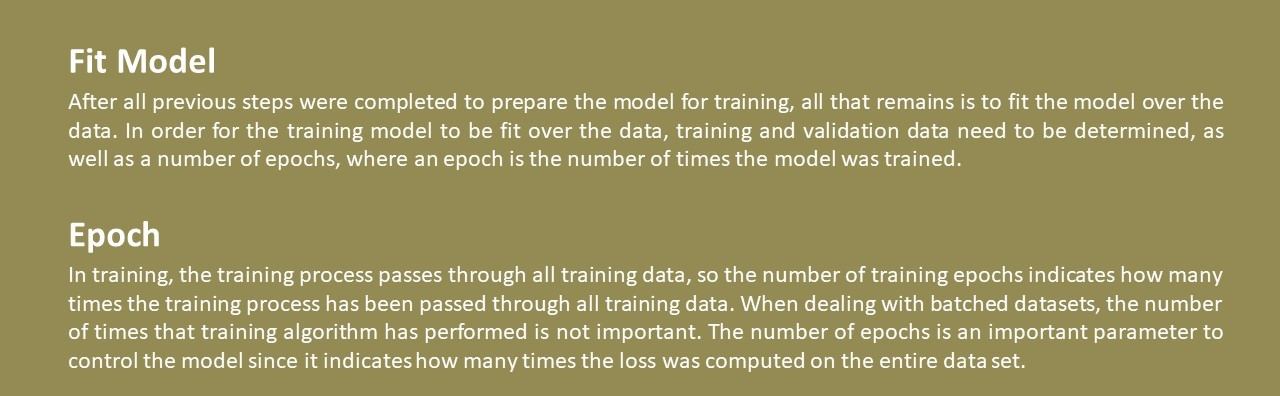

In [ ]:
sup = Object_D_Model()
model, history = sup.training(train_dataset, val_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(16, 448, 448, 3)]       0         
                                                                 
 conv2d (Conv2D)             (16, 224, 224, 8)         1184      
                                                                 
 batch_normalization (BatchN  (16, 224, 224, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (16, 112, 112, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 112, 112, 12)        876       
                                                                 
 batch_normalization_1 (Batc  (16, 112, 112, 12)       48    

None
Epoch 1/50
684/684 [==============================] - 188s 195ms/step - loss: 0.2782 - val_loss: 0.2096
Epoch 2/50
684/684 [==============================] - 147s 189ms/step - loss: 0.1489 - val_loss: 0.1693
Epoch 3/50
684/684 [==============================] - 145s 187ms/step - loss: 0.1325 - val_loss: 0.1561
Epoch 4/50
684/684 [==============================] - 145s 185ms/step - loss: 0.1202 - val_loss: 0.1480
Epoch 5/50
684/684 [==============================] - 145s 187ms/step - loss: 0.1137 - val_loss: 0.1419
Epoch 6/50
684/684 [==============================] - 143s 185ms/step - loss: 0.1066 - val_loss: 0.1471
Epoch 7/50
684/684 [==============================] - 143s 183ms/step - loss: 0.1025 - val_loss: 0.1359
Epoch 8/50
684/684 [==============================] - 145s 185ms/step - loss: 0.0953 - val_loss: 0.1408
Epoch 9/50
684/684 [==============================] - 145s 187ms/step - loss: 0.0913 - val_loss: 0.1598
Epoch 10/50
684/684 [==============================] - 165s

In [ ]:
for images, labels in train_dataset.take(1):
  plt.figure(figsize=(40, 20))
  for num, (image, label) in enumerate(zip(images, labels)):
    pred = model.predict(tf.expand_dims(image, 0))
    pred = np.squeeze(pred)
    plt.subplot(4, 4, num+1)
    plt.imshow(image)
    plt.axis('off')
5
    id_y, id_x = np.where(label[:, :, 0]==1)
    for id in zip(id_y, id_x):
      box_height = label[id[0], id[1], 4]
      box_width = label[id[0], id[1], 3]
      box_center_x = label[id[0], id[1], 1] - box_width/2
      box_center_y = label[id[0], id[1], 2] - box_height/2
      plt.gca().add_patch(Rectangle((448*box_center_x, 448*box_center_y), 448*box_width, 448*box_height, edgecolor='green', lw=1, facecolor='none'))
    id_y, id_x = np.where(pred[:, :, 0]>=0.5)
    for id in zip(id_y, id_x):
      box_height = pred[id[0], id[1], 4]
      box_width = pred[id[0], id[1], 3]
      box_center_x = pred[id[0], id[1], 1] - box_width/2
      box_center_y = pred[id[0], id[1], 2] - box_height/2
      plt.gca().add_patch(Rectangle((448*box_center_x, 448*box_center_y), 448*box_width, 448*box_height, edgecolor='red', lw=1, facecolor='none'))
  plt.show()

In [ ]:
loss = history.history['loss']                                #load training loss of the model
val_loss = history.history['val_loss']                          #load validation loss of the model
fig = plt.figure(figsize=(40, 10))                 #plot accuarcy vs epochs
plt.plot(loss, label='Training Loss', linewidth=3)
plt.plot(val_loss, label='Validation Loss', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Documents/AI book/Chapter 7/my_model.h5')